In [1]:
import warnings
warnings.filterwarnings("ignore")

import io
import random
import numpy as np
from scipy import io
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
from graphviz import Digraph
import math

eps = 1e-5  # a small number

# Code Trees and Forrests

In [2]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=0):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m
        
    def reduce_feature(self, X, y):        
        if self.m == 0:
            self.X = X
            self.y = y            
        else:
            random.seed(42)
            random_idx_m = [random.randint(0,len(X[0])-1) for i in range(self.m)]
            self.X = X.T[random_idx_m].T
            self.y = y
        
        return self.X, self.y
        
    @staticmethod
    def information_gain(X, y, thresh):
        n = len(y)
        n_class0 = list(y).count(0)
        n_class1 = list(y).count(1)

        H = -n_class0/n * np.log2(n_class0/n) - n_class1/n * np.log2(n_class1/n) # initial entropy

        left, right = [], []
        for idx in range(n): 
            if X[idx] < thresh:
                left.append(y[idx])
            else: right.append(y[idx])

        left_n_class0 = list(left).count(0)
        left_n_class1 = list(left).count(1)
        right_n_class0 = list(right).count(0)
        right_n_class1 = list(right).count(1)

        left_H = -left_n_class0/n * np.log2(left_n_class0/n) - left_n_class1/n * np.log2(left_n_class1/n)
        right_H = -right_n_class0/n * np.log2(right_n_class0/n) - right_n_class1/n * np.log2(right_n_class1/n)
        H_after = (len(left)*left_H + len(right)*right_H)/n

        gain = H - H_after
        
        return gain

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]

        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]

        return X0, idx0, X1, idx1

    def fit(self, X_in, y_in):
        # reduce column space for random forrest
        X, y = self.reduce_feature(X_in, y_in)
        
        if self.max_depth > 0:            
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)            
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)                       
            
            if X0.size > 0 and X1.size > 0:                
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1) 
                
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
            
        else:           
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]

        return self
    
    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat


In [3]:
class BaggedTrees:
    def __init__(self, params=None, n_trees=200, max_depth=2, m = 0):
        
        if params is None:
            params = {}
        self.params = params
        if n_trees % 2 != 0:
            self.n_trees = n_trees
        else:
            self.n_trees = n_trees +1
        self.max_depth = max_depth
        self.m = m
        self.decision_trees = [DecisionTree(max_depth=self.max_depth, m = self.m) for i in range(self.n_trees)]

    def bootstrap(self, X, y):
        self.random_idx = [random.randint(0,len(X)-1) for i in range(len(X))]
        self.X_random = X[self.random_idx]
        self.y_random = y[self.random_idx]
        
        return self.X_random, self.y_random
    
    def fit(self, X, y):
        self.fits = []
        random.seed(42)
        for tree in self.decision_trees:
            X, y = BaggedTrees.bootstrap(self, X, y)
            self.fits.append(tree.fit(X, y))
                      
        return self

    def predict(self, X):
        yhat_list = []
        for fit in self.fits:
            yhat = fit.predict(X)
            yhat_list.append(yhat)
        
        yhat_list = np.ravel(yhat_list).reshape(self.n_trees,-1)
        
        # majority vote
        yhat = []
        for i in range(len(X)):
            yhat.append(stats.mode(yhat_list[:,i])[0][0])
        
        return yhat

# Evaluate TITANIC dataset

## Load data

In [4]:
# Titanic data set

In [5]:
# import titanic data

data = pd.read_csv("titanic_clean_train.csv")

print(data.shape)
data.head()

(999, 22)


,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,...,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,pclass_1.0,pclass_2.0,pclass_3.0
0,0.0,30.0,0.0,0.0,8.0500,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0.0,22.0,0.0,0.0,135.6333,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0.0,23.0,0.0,0.0,15.0458,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,42.0,0.0,0.0,13.0000,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,0.0,20.0,0.0,0.0,9.8458,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [6]:
X_train = data.to_numpy()[:800,1:]
y_train = data.to_numpy()[:800,:1][:,0]

X_valid = data.to_numpy()[800:,1:]
y_valid = data.to_numpy()[800:,:1][:,0]

## Predict data and tune hyperparameter

### Decision Trees

In [7]:
# DECISION TREES

accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 20
steps = 20

lst = np.linspace(minimum,maximum,steps)
for i, idx in enumerate(lst):
    dt = DecisionTree(max_depth=np.round(idx))
    dt.fit(X_train,y_train)
    y_train_predict = dt.predict(X_train)
    y_valid_predict = dt.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' max. depth) - ' + 'valid. accuracy: ' + str(accuracy_valid[i]))

5.0% (1.0 max. depth) - valid. accuracy: 0.7939698492462312
10.0% (2.0 max. depth) - valid. accuracy: 0.7638190954773869
15.0% (3.0 max. depth) - valid. accuracy: 0.8090452261306532
20.0% (4.0 max. depth) - valid. accuracy: 0.8140703517587939
25.0% (5.0 max. depth) - valid. accuracy: 0.8040201005025126
30.0% (6.0 max. depth) - valid. accuracy: 0.8040201005025126
35.0% (7.0 max. depth) - valid. accuracy: 0.8241206030150754
40.0% (8.0 max. depth) - valid. accuracy: 0.8291457286432161
45.0% (9.0 max. depth) - valid. accuracy: 0.8090452261306532
50.0% (10.0 max. depth) - valid. accuracy: 0.8140703517587939
55.0% (11.0 max. depth) - valid. accuracy: 0.8040201005025126
60.0% (12.0 max. depth) - valid. accuracy: 0.7939698492462312
65.0% (13.0 max. depth) - valid. accuracy: 0.7989949748743719
70.0% (14.0 max. depth) - valid. accuracy: 0.7939698492462312
75.0% (15.0 max. depth) - valid. accuracy: 0.7989949748743719
80.0% (16.0 max. depth) - valid. accuracy: 0.8040201005025126
85.0% (17.0 max. d

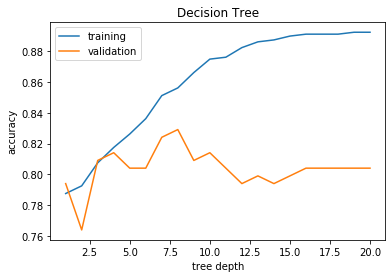

In [8]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Decision Tree')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.legend()

### Bagged Trees

In [9]:
# BAGGED TREES

accuracy_train = []
accuracy_valid = []

minimum = 10
maximum = 100
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    bt = BaggedTrees(n_trees=int(np.round(idx)), max_depth=3)
    bt.fit(X_train,y_train)
    y_train_predict = bt.predict(X_train)
    y_valid_predict = bt.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' trees) - ' + 'accuracy: ' + str(accuracy_train[i]))

10.0% (10.0 trees) - accuracy: 0.79375
20.0% (20.0 trees) - accuracy: 0.7925
30.0% (30.0 trees) - accuracy: 0.79125
40.0% (40.0 trees) - accuracy: 0.7825
50.0% (50.0 trees) - accuracy: 0.7825
60.0% (60.0 trees) - accuracy: 0.7825
70.0% (70.0 trees) - accuracy: 0.78125
80.0% (80.0 trees) - accuracy: 0.7825
90.0% (90.0 trees) - accuracy: 0.7825
100.0% (100.0 trees) - accuracy: 0.75375


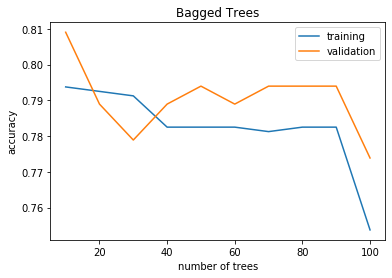

In [10]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Bagged Trees')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.legend()

### Random Forrests

In [11]:
# Random Forrest
# To use a Random Forrest, I initiate a Bagged Tree estimator with m!=0

accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 21
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    rf = BaggedTrees(m=int(np.round(idx)), max_depth=2, n_trees = 120)
    rf.fit(X_train,y_train)
    y_train_predict = rf.predict(X_train)
    y_valid_predict = rf.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' features) - ' + 'accuracy: ' + str(accuracy_train[i]))

10.0% (1.0 features) - accuracy: 0.61
20.0% (3.0 features) - accuracy: 0.61
30.0% (5.0 features) - accuracy: 0.3925
40.0% (8.0 features) - accuracy: 0.6325
50.0% (10.0 features) - accuracy: 0.61875
60.0% (12.0 features) - accuracy: 0.6325
70.0% (14.0 features) - accuracy: 0.3925
80.0% (17.0 features) - accuracy: 0.61125
90.0% (19.0 features) - accuracy: 0.6325
100.0% (21.0 features) - accuracy: 0.63625


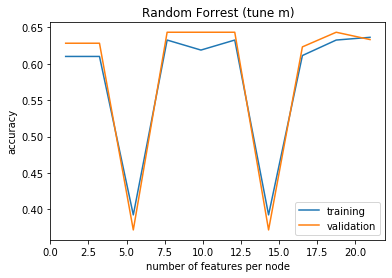

In [12]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Random Forrest (tune m)')
plt.xlabel('number of features per node')
plt.ylabel('accuracy')
plt.legend()

In [13]:
accuracy_train = []
accuracy_valid = []

minimum = 10
maximum = 200
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    rf = BaggedTrees(n_trees=int(np.round(idx)), max_depth=2, m = 5)
    rf.fit(X_train,y_train)
    y_train_predict = rf.predict(X_train)
    y_valid_predict = rf.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' trees) - ' + 'accuracy: ' + str(accuracy_train[i]))

10.0% (10.0 trees) - accuracy: 0.61
20.0% (31.0 trees) - accuracy: 0.3925
30.0% (52.0 trees) - accuracy: 0.3925
40.0% (73.0 trees) - accuracy: 0.3925
50.0% (94.0 trees) - accuracy: 0.3925
60.0% (116.0 trees) - accuracy: 0.3925
70.0% (137.0 trees) - accuracy: 0.3925
80.0% (158.0 trees) - accuracy: 0.3925
90.0% (179.0 trees) - accuracy: 0.3925
100.0% (200.0 trees) - accuracy: 0.3925


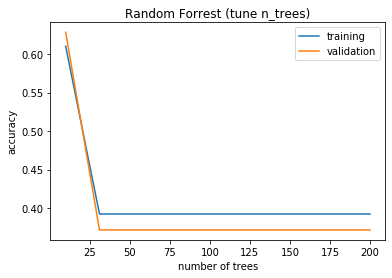

In [14]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Random Forrest (tune n_trees)')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.legend()

## Final prediction with best estimator

In [96]:
# predict test data for Kaggle competition

data_test = pd.read_csv("titanic_clean_test.csv")
data_test.head()

,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,...,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,pclass_1.0,pclass_2.0,pclass_3.0
0,0.0,24.0,0.0,0.0,69.3000,1,0,1,0,0,...,1,0,0,0,0,0,0.0,1,0,0
1,0.0,44.0,0.0,1.0,57.9792,1,0,1,0,0,...,1,0,0,0,0,0,0.0,1,0,0
2,0.0,1.0,5.0,2.0,46.9000,0,1,0,0,1,...,0,0,0,0,0,1,0.0,0,0,1
3,0.0,29.0,0.0,0.0,7.8750,0,1,0,0,1,...,0,0,0,0,0,1,0.0,0,0,1
4,0.0,30.0,0.0,0.0,13.0000,0,1,0,0,1,...,0,0,0,0,0,1,0.0,0,1,0


In [97]:
X_test = data_test.to_numpy()

In [128]:
dt = BaggedTrees(max_depth=2, n_trees=40)
dt.fit(X_train,y_train)

y_test_predict = dt.predict(X_test)

In [129]:
# A code snippet to help you save your results into a kaggle accepted csv
# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_titanic.csv', index_label='Id')

results_to_csv(np.array(y_test_predict))

# SPAM dataset

## Load data

In [4]:
data = io.loadmat("data/spam_data.mat")
print("\nloaded data!")
fields = "test_data", "training_data", "training_labels"
for field in fields:
    print(field, data[field].shape)


loaded data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (1, 5172)


In [6]:
X_train = data['training_data'][:4100]
y_train = data['training_labels'][0][:4100]
X_valid = data['training_data'][4100:]
y_valid = data['training_labels'][0][4100:]

X_test = np.array(data['test_data'])

## Predict data and tune hyperparameter

### Decision Trees

In [17]:
# DECISION TREES

accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 20
steps = 20

lst = np.linspace(minimum,maximum,steps)
for i, idx in enumerate(lst):
    dt = DecisionTree(max_depth=np.round(idx))
    dt.fit(X_train,y_train)
    y_train_predict = dt.predict(X_train)
    y_valid_predict = dt.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' max. depth) - ' + 'valid. accuracy: ' + str(accuracy_valid[i]))

5.0% (1.0 max. depth) - valid. accuracy: 0.8348880597014925
10.0% (2.0 max. depth) - valid. accuracy: 0.8600746268656716
15.0% (3.0 max. depth) - valid. accuracy: 0.8647388059701493
20.0% (4.0 max. depth) - valid. accuracy: 0.8740671641791045
25.0% (5.0 max. depth) - valid. accuracy: 0.8134328358208955
30.0% (6.0 max. depth) - valid. accuracy: 0.8106343283582089
35.0% (7.0 max. depth) - valid. accuracy: 0.832089552238806
40.0% (8.0 max. depth) - valid. accuracy: 0.8302238805970149
45.0% (9.0 max. depth) - valid. accuracy: 0.8246268656716418
50.0% (10.0 max. depth) - valid. accuracy: 0.8302238805970149
55.0% (11.0 max. depth) - valid. accuracy: 0.8376865671641791
60.0% (12.0 max. depth) - valid. accuracy: 0.835820895522388
65.0% (13.0 max. depth) - valid. accuracy: 0.8311567164179104
70.0% (14.0 max. depth) - valid. accuracy: 0.8376865671641791
75.0% (15.0 max. depth) - valid. accuracy: 0.8395522388059702
80.0% (16.0 max. depth) - valid. accuracy: 0.8423507462686567
85.0% (17.0 max. dep

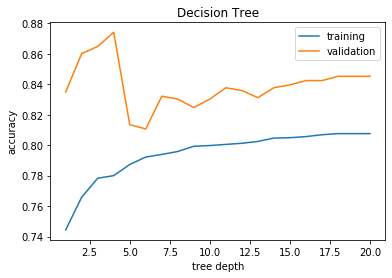

In [18]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Decision Tree')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.legend()

### Bagged Trees

In [19]:
# BAGGED TREES

accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 10
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    bt = BaggedTrees(n_trees=int(np.round(idx)), max_depth=4)
    bt.fit(X_train,y_train)
    y_train_predict = bt.predict(X_train)
    y_valid_predict = bt.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' trees) - ' + 'valid. accuracy: ' + str(accuracy_valid[i]))

10.0% (1.0 trees) - valid. accuracy: 0.8078358208955224
20.0% (2.0 trees) - valid. accuracy: 0.8460820895522388
30.0% (3.0 trees) - valid. accuracy: 0.8460820895522388
40.0% (4.0 trees) - valid. accuracy: 0.8610074626865671
50.0% (5.0 trees) - valid. accuracy: 0.8610074626865671
60.0% (6.0 trees) - valid. accuracy: 0.8628731343283582
70.0% (7.0 trees) - valid. accuracy: 0.8628731343283582
80.0% (8.0 trees) - valid. accuracy: 0.8488805970149254
90.0% (9.0 trees) - valid. accuracy: 0.8488805970149254
100.0% (10.0 trees) - valid. accuracy: 0.8460820895522388


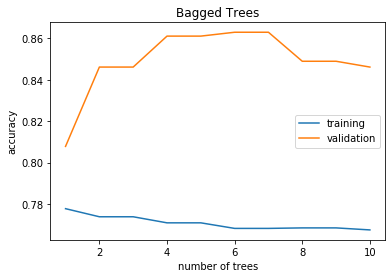

In [20]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Bagged Trees')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.legend()

### Random Forrests

In [21]:
# Random Forrest
# To use a Random Forrest, I initiate a Bagged Tree estimator with m!=0

accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 21
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    rf = BaggedTrees(m=int(np.round(idx)), max_depth=2, n_trees = 10)
    rf.fit(X_train,y_train)
    y_train_predict = rf.predict(X_train)
    y_valid_predict = rf.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' features) - ' + 'valid. accuracy: ' + str(accuracy_valid[i]))

10.0% (1.0 features) - valid. accuracy: 1.0
20.0% (3.0 features) - valid. accuracy: 0.9934701492537313
30.0% (5.0 features) - valid. accuracy: 0.976679104477612
40.0% (8.0 features) - valid. accuracy: 1.0
50.0% (10.0 features) - valid. accuracy: 0.9972014925373134
60.0% (12.0 features) - valid. accuracy: 0.976679104477612
70.0% (14.0 features) - valid. accuracy: 0.980410447761194
80.0% (17.0 features) - valid. accuracy: 0.9151119402985075
90.0% (19.0 features) - valid. accuracy: 0.957089552238806
100.0% (21.0 features) - valid. accuracy: 0.957089552238806


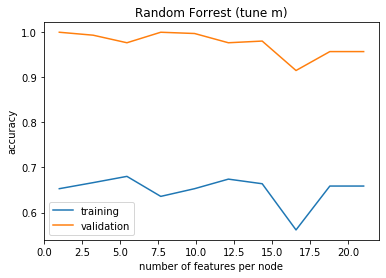

In [22]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Random Forrest (tune m)')
plt.xlabel('number of features per node')
plt.ylabel('accuracy')
plt.legend()

In [23]:
accuracy_train = []
accuracy_valid = []

minimum = 1
maximum = 20
steps = 10
lst = np.linspace(minimum,maximum,10)
for i, idx in enumerate(lst):
    rf = BaggedTrees(n_trees=int(np.round(idx)), max_depth=2, m = 8)
    rf.fit(X_train,y_train)
    y_train_predict = rf.predict(X_train)
    y_valid_predict = rf.predict(X_valid)
    
    accuracy_train.append(list(y_train_predict-y_train).count(0) / len(y_train))
    accuracy_valid.append(list(y_valid_predict-y_valid).count(0) / len(y_valid))
    
    print(str(100*(i+1)/steps) + '% (' + str(np.round(idx)) + ' trees) - ' + 'valid. accuracy: ' + str(accuracy_valid[i]))

10.0% (1.0 trees) - valid. accuracy: 0.976679104477612
20.0% (3.0 trees) - valid. accuracy: 0.976679104477612
30.0% (5.0 trees) - valid. accuracy: 1.0
40.0% (7.0 trees) - valid. accuracy: 1.0
50.0% (9.0 trees) - valid. accuracy: 1.0
60.0% (12.0 trees) - valid. accuracy: 1.0
70.0% (14.0 trees) - valid. accuracy: 1.0
80.0% (16.0 trees) - valid. accuracy: 1.0
90.0% (18.0 trees) - valid. accuracy: 1.0
100.0% (20.0 trees) - valid. accuracy: 1.0


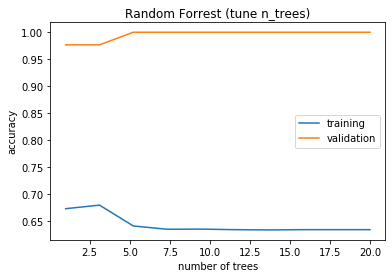

In [24]:
fig, ax = plt.subplots()
ax.plot(lst, accuracy_train, label='training') 
ax.plot(lst, accuracy_valid, label='validation')
plt.title('Random Forrest (tune n_trees)')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.legend()

## Final prediction with best estimator

In [7]:
X_train = data['training_data']
y_train = data['training_labels'][0]

In [8]:
dt = BaggedTrees(max_depth=2, n_trees=10, m=8)
dt.fit(X_train,y_train)

y_test_predict = dt.predict(X_test)

In [9]:
# A code snippet to help you save your results into a kaggle accepted csv
# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_spam.csv', index_label='Id')

results_to_csv(np.array(y_test_predict))